In [1]:
import requests
import pandas as pd
from vega_datasets import data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.linear_model import LassoLars
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Project and goals
## Analysis and Modeling of Alaskan Snow Crab Data (1975 - 2018)
## Provide data for convservation and 'State of the Species'

# Plan and Breakdown
## Acquire and Prep data
## Explore
    Seasonality and Continous Variable Analysis
## Modeling
    Time Series and Regression
## Lessons Learned

# Acquisition and Prep
## Data acquired via Kaggle and cleaned
    CPUE outliers removed
    Year converted to DT Group
    ID, Name, Haul# dropped
    DT set averaged CPUE down to year
    Regression set broken into Train, Validate, and Test sets

In [2]:
df , df_time = wrangle.get_snow_crabs()

In [3]:
train, val , test = wrangle.train_val_test(df)

In [53]:

print(df_time.head())
train.head()

                     cpue
year                     
1975-12-31   76198.576087
1976-12-31   42832.097938
1977-12-31  107108.323810
1978-12-31   31497.604430
1979-12-31   59850.594595


,latitude,longitude,year,sex,bottom_depth,surface_temperature,bottom_temperature,cpue
4224,58.32467,-165.89359,1987-01-01,female,42,4.1,3.4,77
1303,57.66500,-163.99000,1980-01-01,male,49,3.3,1.3,21400
9406,56.65711,-171.35161,1999-01-01,male,117,6.6,2.7,3413
6165,58.28592,-173.55558,1991-01-01,female,117,10.0,2.5,84660
1646,56.83500,-169.87384,1981-01-01,male,73,6.9,5.8,3281


# Explore
## Exploration guided by 4 main questions:
- Does CPUE Size exhibit a seasonality trend?
- Is there a correlation between CPUE and Seafloor Temperature?
- Is there a correlation between CPUE and Surface Temperature?
- Is there a correlation between depth of catch and CPUE?

## Seasonality
    𝐻0 : There is no notable seasonal trend in snow crab CPUE.
    𝐻𝑎 : There is a quantifiable trend in seasonality of CPUE.

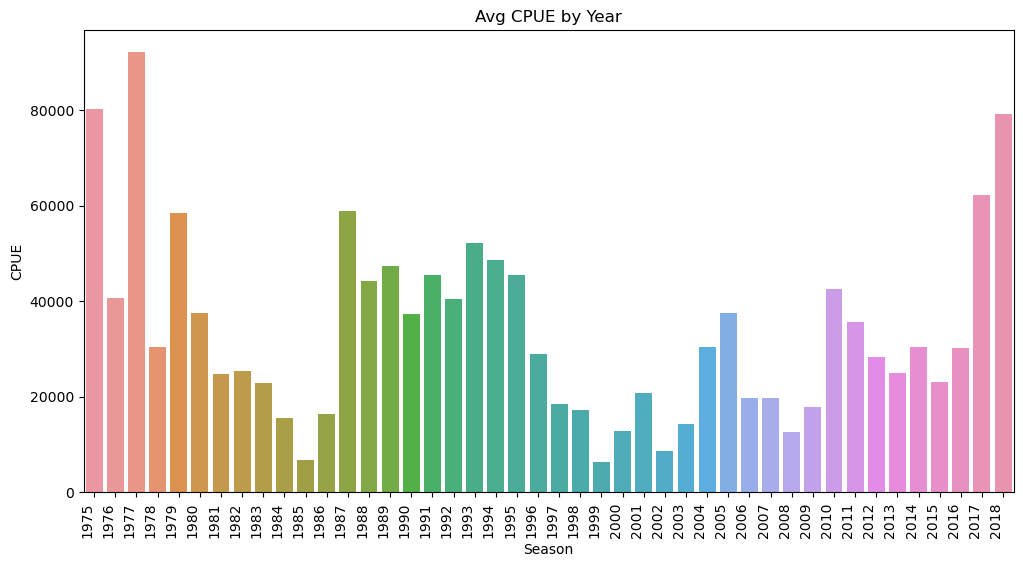

In [54]:
yr_labels = []
for yr in range(1975, 2019):
    yr_labels.append(f'{yr}')
plot_001 = pd.DataFrame(train.groupby('year').mean())


plt.subplots(figsize = (12,6))
fig = sns.barplot(data = plot_001, x = plot_001.index, y = 'cpue')

plt.title('Avg CPUE by Year')
plt.xlabel('Season')
plt.ylabel('CPUE')
fig.set_xticklabels(labels=yr_labels, rotation=90, ha='right')
plt.show()

## Relatively clear seasonality trend 
### Questionable regularity; definitely in multiple years

## CPUE and Seafloor Temperature
    𝐻0 : There is no correlation between CPUE and Seafloor Temperature.
    𝐻𝑎 : There is correlation between CPUE and Seafloor Temperature.

In [8]:
train_lim = train[train['cpue'] < 600000]
train_lim = train_lim[train_lim['bottom_depth'] < 200]
train_lim = train_lim[train_lim['bottom_temperature'] < 8.5]

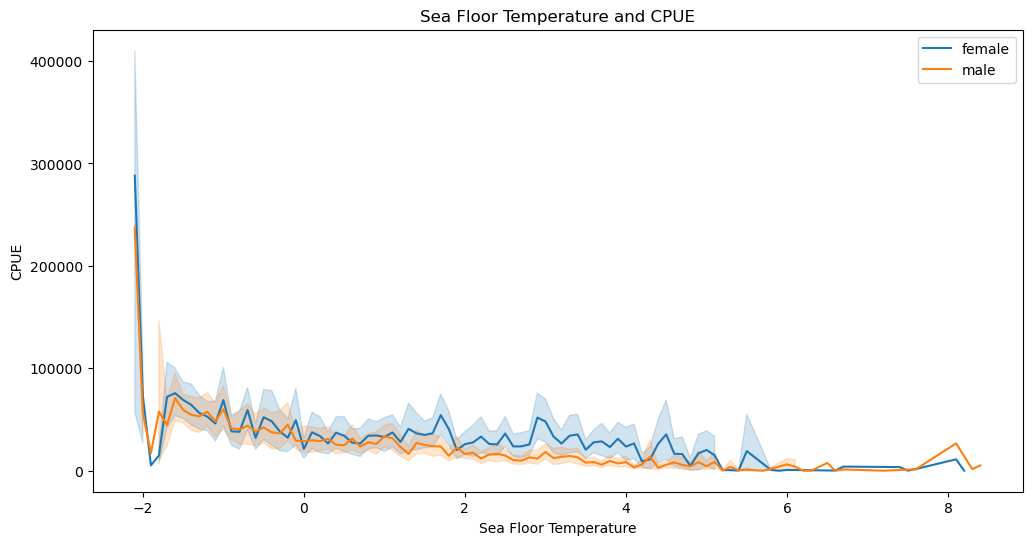

In [9]:
plt.subplots(figsize = (12,6))
sns.lineplot(data=train_lim[train_lim['sex'] == 'female'], x="bottom_temperature", y="cpue", label = 'female')
sns.lineplot(data=train_lim[train_lim['sex'] == 'male'], x="bottom_temperature", y="cpue", label = 'male')
plt.title('Seafloor Temperature and CPUE')
plt.xlabel('Seafloor Temperature')
plt.ylabel('CPUE')
plt.legend()
plt.show()


### P-Value close to Zero and a negative Corr implies a quantifiable relationship

In [10]:
stats.spearmanr(train['cpue'], train['bottom_temperature'])

SpearmanrResult(correlation=-0.38732964457546915, pvalue=0.0)

## Surface Temperature and CPUE
    𝐻0 : There is no correlation between CPUE and Surface Temperature.
    𝐻𝑎 : There is correlation between CPUE and Surface Temperature.

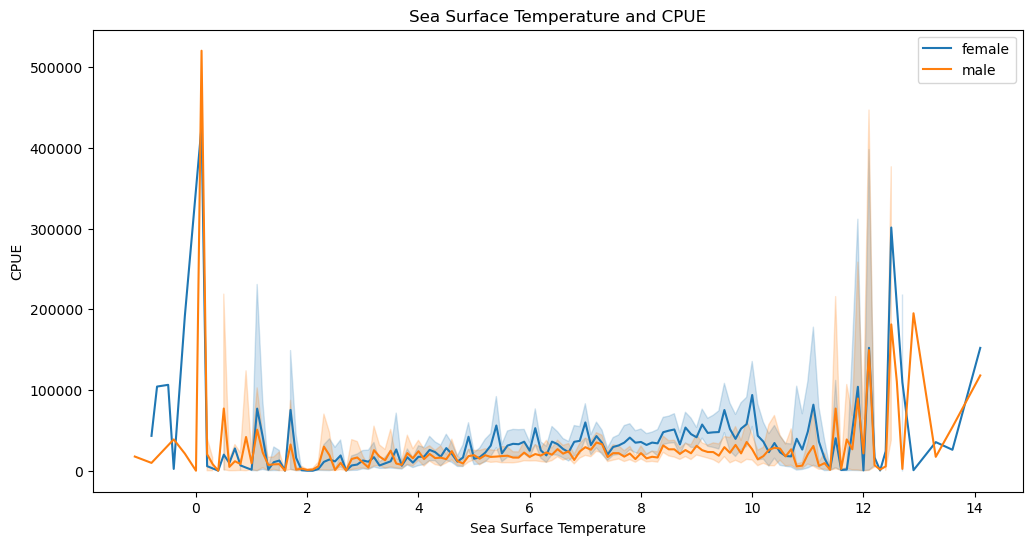

In [11]:
plt.subplots(figsize = (12,6))
sns.lineplot(data=train_lim[train_lim['sex'] == 'female'], x="surface_temperature", y="cpue", label = 'female')
sns.lineplot(data=train_lim[train_lim['sex'] == 'male'], x="surface_temperature", y="cpue", label = 'male')
plt.title('Sea Surface Temperature and CPUE')
plt.xlabel('Sea Surface Temperature')
plt.ylabel('CPUE')
plt.legend()
plt.show()

### Low P-Value indicates a correlation but low correlation score indicates a weak relationship

In [55]:
stats.spearmanr(train['cpue'], train['surface_temperature'])

SpearmanrResult(correlation=0.0906877885365029, pvalue=2.5119818381322743e-24)

## Traul Depth and CPUE

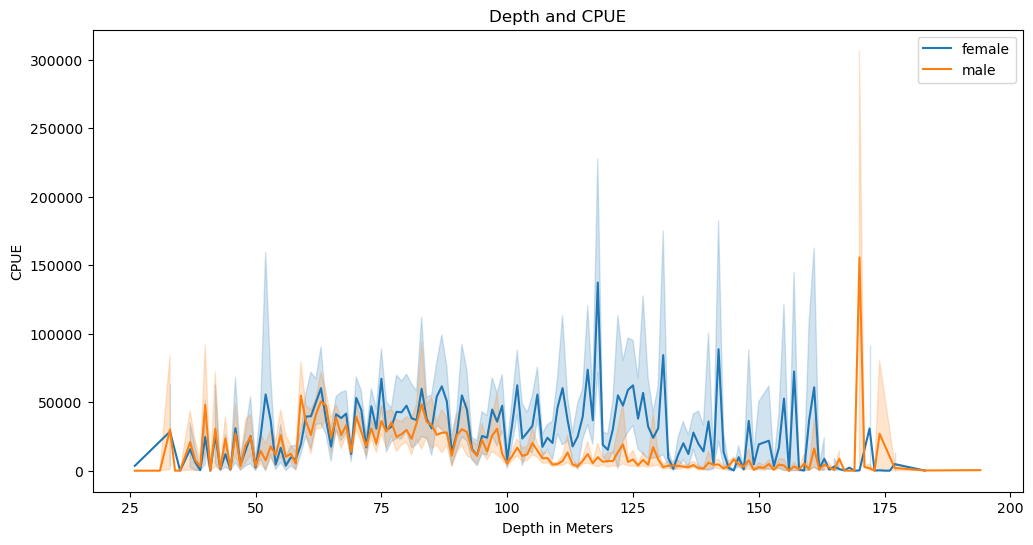

In [56]:
plt.subplots(figsize = (12,6))
sns.lineplot(data=train_lim[train['sex'] == 'female'] , x="bottom_depth", y="cpue", label = 'female')
sns.lineplot(data=train_lim[train['sex'] == 'male'] , x="bottom_depth", y="cpue", label = 'male')
plt.title('Depth and CPUE')
plt.xlabel('Depth in Meters')
plt.ylabel('CPUE')
plt.legend()
plt.show()

### Low P score implies a relationship but questionable strength

In [58]:
stats.spearmanr(train['cpue'], train['bottom_depth'])

SpearmanrResult(correlation=-0.1003311053815531, pvalue=1.966968227123919e-29)

# Exploration Takeaways
- Temperature has a correlation with weight on depth where they are collected
- Acutal depth has some correlation but is more likely related to factors surrounding the depth such as temp and bio-diversity in the location
- Seasonality trend seems to exist at or near a decade level

# Modeling
## Time Series: Holts Seasonal Trend

In [60]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
df_time = pd.DataFrame(df_time.resample('y')['cpue'].mean())
train_t, val_t, test_t = modeling.time_split(df_time)

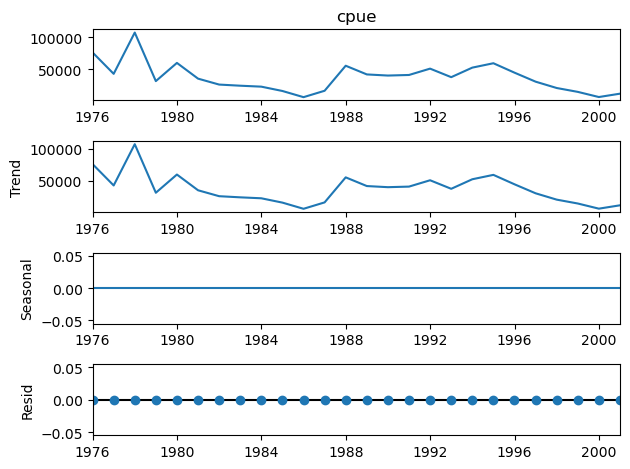

In [61]:
sm.tsa.seasonal_decompose(train_t['cpue'].resample('1y').mean()).plot()
None

cpue -- RMSE: 19589


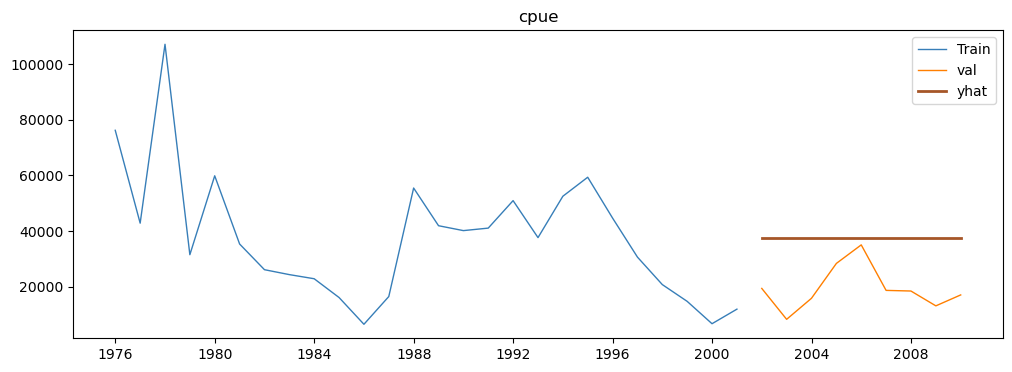

In [62]:
baseline = round(train_t['cpue'].mean(), 4)
yhat_df = modeling.make_baseline_predictions(baseline, val_t)
modeling.plot_and_eval('cpue', train_t, val_t, yhat_df)

In [63]:
eval_df = modeling.append_eval_df('simple_mean', 'cpue', val_t, yhat_df, eval_df)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0


cpue -- RMSE: 12265


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


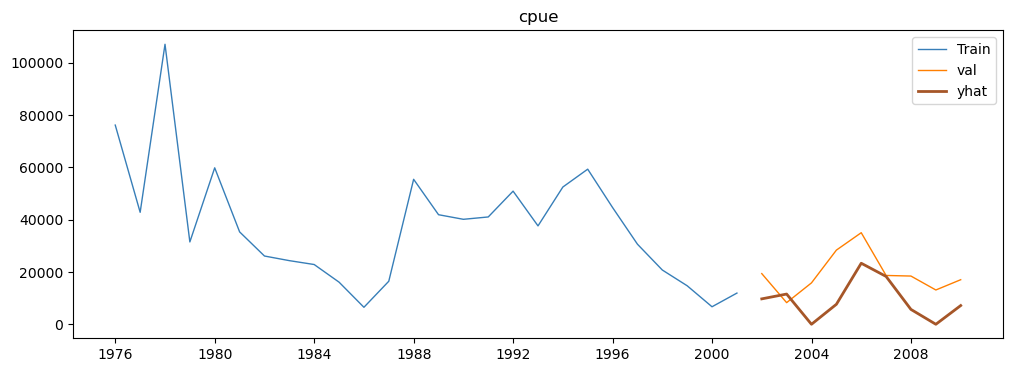

In [64]:
hst_cpue = ExponentialSmoothing(train_t.cpue, seasonal_periods=9, 
                                trend='add', seasonal='add', damped = True).fit()

hst_preds = hst_cpue.forecast(val_t.shape[0])

hst_preds[hst_preds < 0] = 0

yhat_df = pd.DataFrame({'cpue': hst_preds},
                          index=val_t.index)

modeling.plot_and_eval('cpue', train_t, val_t, yhat_df)

In [65]:
eval_df = modeling.append_eval_df('holts_seasonal', 'cpue', val_t, yhat_df, eval_df)
eval_df.head()

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0
1,holts_seasonal,cpue,12265.0


# Regression: Tweedie Regression


In [32]:
x_train, y_train, x_val, y_val, x_test, y_test = modeling.modeling_prep(train, val, test)
preds_df = pd.DataFrame(train['cpue'])



In [66]:
tweedie = TweedieRegressor(power = 1, alpha = 1)
tweedie.fit(x_train, y_train)
tweedie_preds = tweedie.predict(x_train)
tweedie_preds[tweedie_preds < 0] = 0

In [70]:
preds_df['baseline'] = preds_df['cpue'].mean()
preds_df['tweedie'] = tweedie_preds
tweedie_rmse = sqrt(mean_squared_error(preds_df['tweedie'], preds_df['cpue']))
eval_df = eval_df.append({'model_type':'Tweedie', 'target_var':'cpue','rmse':tweedie_rmse}, ignore_index=True)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.00000
1,holts_seasonal,cpue,12265.00000
2,Tweedie,cpue,83310.55676
3,Tweedie,cpue,83310.55676


# Regression: Polynomial Regression

In [71]:
pf = PolynomialFeatures(degree = 2)
pf.fit(x_train, y_train)
x_poly=pf.transform(x_train)
lm = LinearRegression()
lm.fit(x_poly, y_train)

poly_preds = lm.predict(x_poly)
poly_preds[poly_preds < 0] = 0
preds_df['poly_preds'] = poly_preds
poly_rmse = sqrt(mean_squared_error(preds_df['poly_preds'], preds_df['cpue']))

In [44]:
eval_df = eval_df.append({'model_type':'Poly_Reg', 'target_var':'cpue','rmse':poly_rmse}, ignore_index=True)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.000000
1,holts_seasonal,cpue,12265.000000
2,Tweedie,cpue,83310.556760
3,Poly_Reg,cpue,79415.132597


# Test Set: Holts Seasonal Trend

In [47]:
yhat_df = pd.DataFrame({'cpue': hst_cpue.forecast(val_t.shape[0] + test_t.shape[0])})
yhat_df=yhat_df['2010-12-31':'2018-12-31']

In [49]:
rmse_temp_total = sqrt(mean_squared_error(test_t['cpue'], yhat_df['cpue']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-temp total:  43468.69397315249


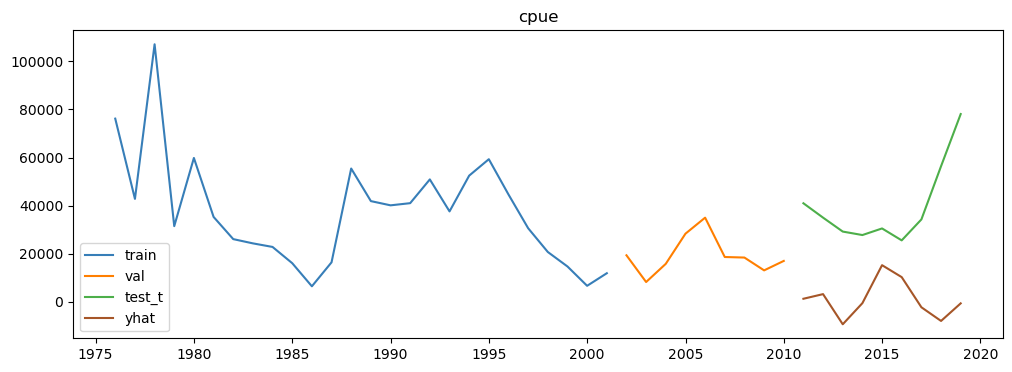

In [50]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-temp total: ', rmse_temp_total)
modeling.final_plot('cpue', train_t, val_t, test_t, yhat_df)

# Modeling Takeaways
## Time series performed the best in validate but failed to generate a trend in test that would inform decisions in reality
## Seasonality trends in CPUE more than likely have a literal sea of variables influencing them

# Future Steps
- look at more environmental variables that influence snow crab mating conditions
- look more at seafloor temperature trends and currents
- more indepth geospatial analysis and catch content analysis


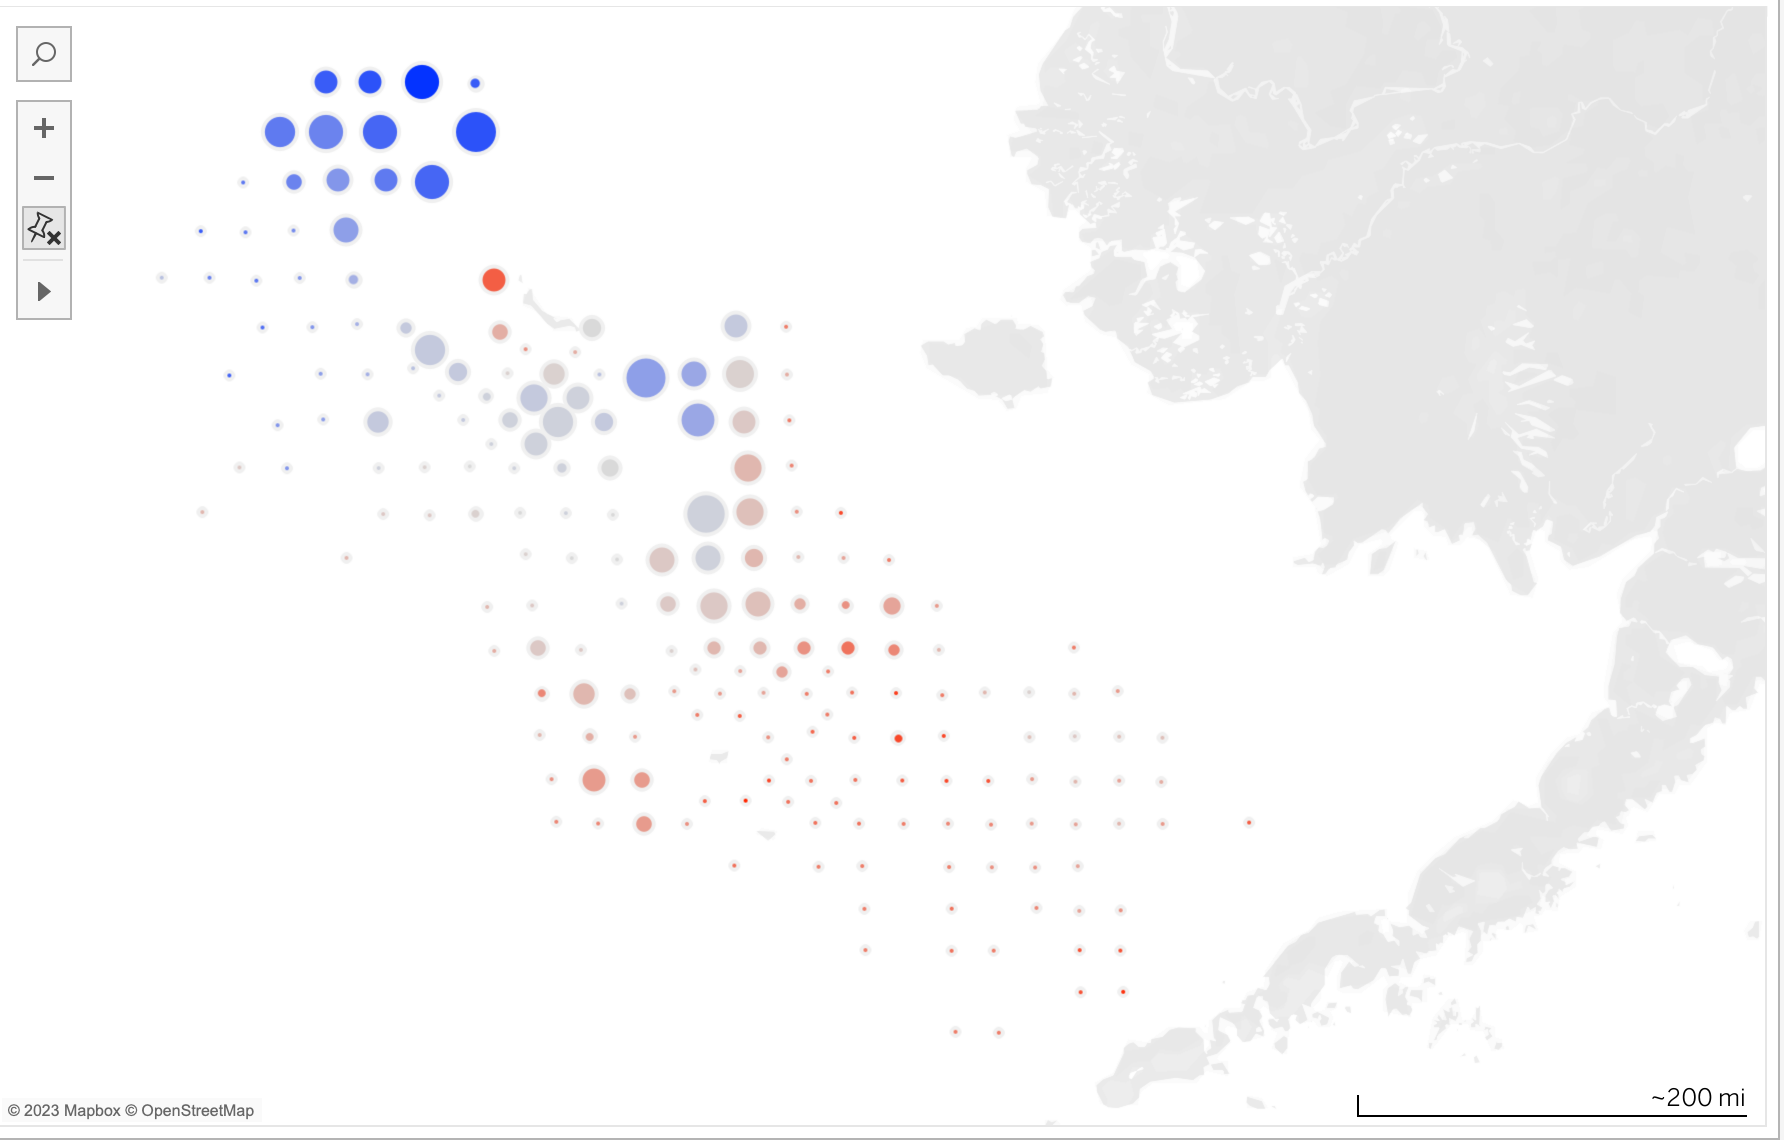